In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import time
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
import os
from sklearn.metrics import confusion_matrix

In [4]:
SPECTRUM_IMAGES_CLASSES_TRAIN = '../GeneratedData/urban-sound-classification/train/Train/'
SPECTRUM_IMAGES_CLASSES_TEST = ''
INPUT_RESOLUTION = 224

In [6]:
SPECTRUM_IMAGES_CLASSES_TRAIN = '../GeneratedData/Cats-Vs-Dogs/'
SPECTRUM_IMAGES_CLASSES_TEST = ''
INPUT_RESOLUTION = 224

In [3]:
SPECTRUM_IMAGES_CLASSES_TRAIN = '../GeneratedData/audio-cats-and-dogs/cats_dogs/train/'
SPECTRUM_IMAGES_CLASSES_TEST = '../GeneratedData/audio-cats-and-dogs/cats_dogs/test/'
INPUT_RESOLUTION = 224

In [7]:
transform = transforms.Compose(
    [transforms.Resize(INPUT_RESOLUTION),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset=[]
testset=[]
NoTestSet=False
full_dataset=None
if len(SPECTRUM_IMAGES_CLASSES_TEST)==0:
    print("Using one data set and sperating them with an 80%/20% split")
    full_dataset = torchvision.datasets.ImageFolder(root=SPECTRUM_IMAGES_CLASSES_TRAIN, transform=transform)
    full_DataLoader = torch.utils.data.DataLoader(full_dataset, batch_size=4, shuffle=True, num_workers=2)
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    trainset, testset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    NoTestSet=True
else:
    print("Using pre-seperated test and training data sets!")
    trainset = torchvision.datasets.ImageFolder(root=SPECTRUM_IMAGES_CLASSES_TRAIN, transform=transform)
    testset = torchvision.datasets.ImageFolder(root=SPECTRUM_IMAGES_CLASSES_TEST, transform=transform)
    

trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
classes=None
if(NoTestSet):
    classes = full_DataLoader.dataset.classes
else:
    classes = trainloader.dataset.classes

print(classes)


Using one data set and sperating them with an 80%/20% split
['Cats', 'Dogs']


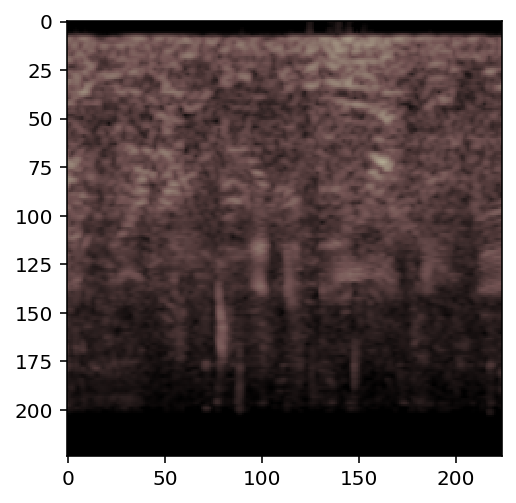

Dogs


In [12]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
for i in range(trainloader.batch_size):
    imshow(images[i])
    print(classes[labels[i]])

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=False)

In [58]:
ModelData = torch.load('../Models/MainModelUrban.pth',map_location='cpu')
model.load_state_dict(ModelData['model'])
# IncompatibleKeys(missing_keys=[], unexpected_keys=[]) Means it was succesfull

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [59]:
for param in model.parameters():
    param.requires_grad = False
    
    
model.fc = nn.Linear(512, len(classes)) # assuming that the fc7 layer has 512 neurons, otherwise change it 

In [60]:
print(device)
if device.type=='cuda':
    model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train_epoch_losses=[]
test_epoch_losses=[]
epoch=0

cpu


In [ ]:
for i in range(5):  # loop over the dataset multiple times
    epoch+=1
    print("Starting epoch:",epoch)
    epochLoss=0.0
    t0 = time.time()
    model.train()
    for i, data in enumerate(trainloader, 0):
        #print("Running Batches",i)
        # get the inputs
        inputs, labels = data
        if device.type=='cuda':
            inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        if(i%200==0):
            print('At data point',i,time.time()-t0)
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epochLoss+=loss.item()
        #break;
    
    model.eval()
    testLoss=0
    print("About to test the performance on the test set.")
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            # get the inputs
            inputs, labels = data
            if device.type=='cuda':
                inputs, labels = inputs.to(device), labels.to(device)
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            testLoss+=loss.item()
            if(i%50==0):
                print('Testing at data point',i,time.time()-t0)
    
    train_epoch_losses.append(epochLoss/len(trainloader))
    test_epoch_losses.append(testLoss/len(testloader))
    EpochLength = time.time()-t0
    print('{} train loss: {:.3f} and test loss: {:.3f}, and it took us: {:.2f} seconds.'.format (epoch + 1, epochLoss / len(trainloader),testLoss/len(testloader),EpochLength))  # DAVID CHanged it to 1000 from 2000 not sure if thats totally done

print('Finished Training')


Starting epoch: 1
At data point 0 0.05387067794799805
At data point 200 9.630371809005737
At data point 400 20.289596796035767
At data point 600 32.795822858810425
At data point 800 45.98610877990723
At data point 1000 58.471346855163574
At data point 1200 71.03372883796692
At data point 1400 84.07911396026611
At data point 1600 96.85132384300232
At data point 1800 109.88465881347656
At data point 2000 121.7826578617096
At data point 2200 133.33976078033447
At data point 2400 145.23263692855835
At data point 2600 156.87265372276306
At data point 2800 168.81867289543152
At data point 3000 180.73502779006958
At data point 3200 194.1861288547516
At data point 3400 207.3955397605896
At data point 3600 221.21443462371826
At data point 3800 234.58296871185303
At data point 4000 247.18554186820984
At data point 4200 259.9434139728546
At data point 4400 272.0292217731476
At data point 4600 283.8021938800812
At data point 4800 296.2169108390808
At data point 5000 309.0314428806305
At data point

In [ ]:
torch.save({
    'model':model.state_dict(),
    'classes':classes,
    'resolution':INPUT_RESOLUTION,
    'modelType':"resnet18" # <= If you try out different models make sure to change this too
},"../models/CatDogResNet.pth") # <=Edit file name here 

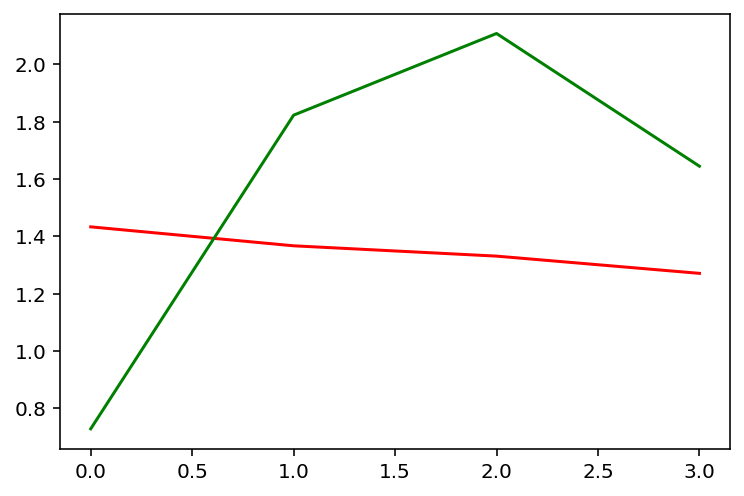

In [50]:
plt.plot(train_epoch_losses, label='Training Loss',c='r')
plt.plot(test_epoch_losses, label='Test Loss',c='g')
plt.show()

In [ ]:
dataiter = iter(testloader)
model.eval()
for j in range (2):
    images, labels = dataiter.next()
    if device == 'cuda':
        images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    for i in range(len(images)):
        imshow(images[i])
        print('GroundTruth: ',classes[labels[i]])
        print('Predicted: ',  classes[predicted[i]])


In [ ]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
model.eval()
allLabels=[]
allPrediction=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(testloader.batch_size):
            if(len(labels)<=i):
                continue;
            label = labels[i]
            allLabels.append(labels[i].to('cpu').numpy())
            allPrediction.append(predicted[i].to('cpu').numpy())
            if(testloader.batch_size>1):
                class_correct[label] += c[i].item()
            else:
                class_correct[label] += c.item()
            class_total[label] += 1

print(confusion_matrix(allLabels, allPrediction))
for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
count=0
for params in model.parameters():
    print(params.requires_grad)


In [45]:
for param in model.parameters():
    param.requires_grad = False
    # Replace the last fully-connected layer
    # Parameters of newly constructed modules have requires_grad=True by default
model.fc = nn.Linear(512, 2) # assuming that the fc7 layer has 512 neurons, otherwise change it 

In [ ]:
model